# Introduction

This notebook shows the steps to create groups of competing neural networks in a speculative investing environment. Brokers evaluate the state of a simulated ecosystem, and compete in an auction to invest in various creatures. They are then rewarded for population changes related to stocks they hold. This results in price discovery that responds to competition in other stocks, as well as relative uncertainty.

The motivation is to provide an example of a solution to a non-trivial valuation problem built from first principles. The source code has been written to be interpretable by someone unspecialised in machine learning, and to convey an intuition of machine learning practical enough for creative nonsense.


# Ecosystems

In order to work with swarms of betting algorithms in a market, we first need something for them to bet and speculate about. A predatory ecosystem produces chaotic-looking population dynamics with only a small number of simple relationships.

In [1]:
import ecosystems
import creatures
import brokerage
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import math
import statistics
random.seed(0)

## Simple Ecosystem Example

First, lets take a look at the dynamics of a linear food chain with one primary producer and two consumers.

In [2]:
# Initialise ecosystem environment.
ecosystem = ecosystems.PairwiseInteractionEnvironment()

# Add a sizable population of three dynamic entities, and some rocks for bias.
ecosystem.add_entities([creatures.BoringRock() for _ in range(100)])
ecosystem.add_entities([creatures.DeliciousLettuce() for _ in range(100)])
ecosystem.add_entities([creatures.Caterpillar() for _ in range(80)])
ecosystem.add_entities([creatures.Bluebird() for _ in range(40)])

In [3]:
populations = {
    'Bird': [], 
    'Caterpillar': [], 
    'Lettuce': [], 
    'Rock': [], 
}

# Collect population values for a large number of steps.
for i in range(2000):
    
    # Each step causes each entity in the environment to act or be acted upon.
    ecosystem.step()
    for key in populations.keys():
        populations[key].append(sum([1 for entity in ecosystem.entities if entity.stock_name == key]))

<AxesSubplot:title={'center':'Entity Populations over Simulation'}>

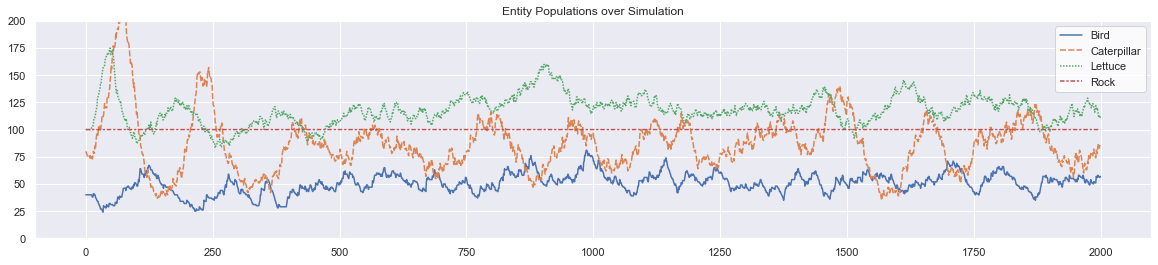

In [4]:
# Plot the populations over these iterations.
sns.set(rc={"figure.figsize":(20, 4)})
plt.ylim(0, 200)
sns.set_style("whitegrid")
plt.title('Entity Populations over Simulation')
sns.lineplot(data=populations)

Once the populations stabilise by step 500, we can see a strong causal relationship. A rise in caterpillars will cause a crash in lettuces, which in turn will cause the caterpillar population to crash back down. We see the the same in the relationship between birds and caterpillars, with bird populations growing to meet new food supply and affecting that source.

Although the environment contains simple cause and effect in population growths, we already see the dynamics necessary for somewhat diverse situations for predictive models. The addition of just a few more entity types should improve complexity to the degree we need, so lets add some raptors.


## A More Complex Example

<AxesSubplot:>

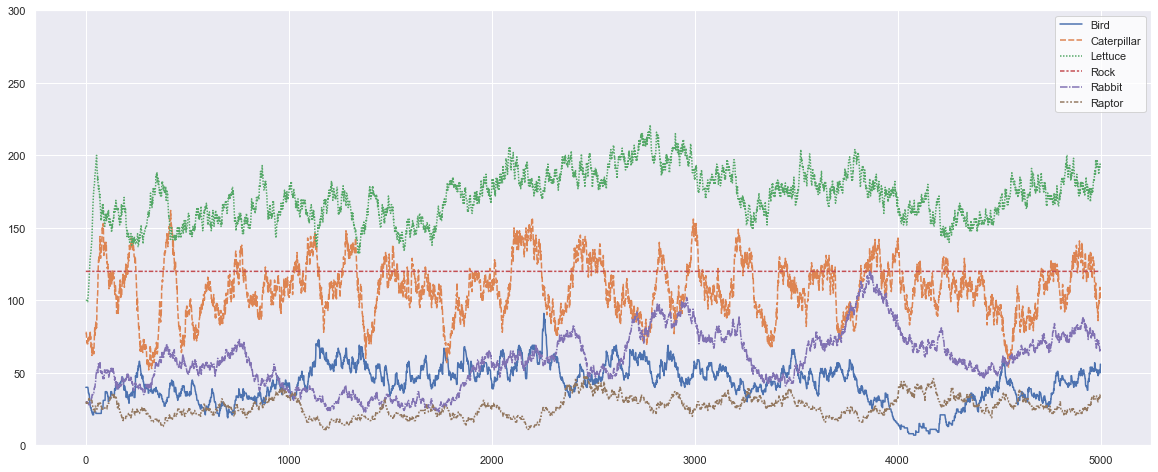

In [5]:
ecosystem = ecosystems.PairwiseInteractionEnvironment()
ecosystem.add_entities([creatures.BoringRock() for _ in range(120)])
ecosystem.add_entities([creatures.DeliciousLettuce() for _ in range(100)])
ecosystem.add_entities([creatures.Caterpillar() for _ in range(80)])
ecosystem.add_entities([creatures.Bluebird() for _ in range(40)])
ecosystem.add_entities([creatures.Rabbit() for _ in range(30)])
ecosystem.add_entities([creatures.Raptor() for _ in range(30)])

populations = {
    'Bird': [], 
    'Caterpillar': [], 
    'Lettuce': [], 
    'Rock': [], 
    'Rabbit': [],
    'Raptor': [],
}

for i in range(5000):
    ecosystem.step()
    for key in populations.keys():
        populations[key].append(sum([1 for entity in ecosystem.entities if entity.stock_name == key]))

        
sns.set(rc={"figure.figsize":(20, 8)})
plt.ylim(0, 300)
sns.set_style("whitegrid")
sns.lineplot(data=populations)

Rabbits are competing with caterpillars for lettuce, and raptors are predators of both rabbits and caterpillars (preferring to eat rabbits). Now we have a complex enough food web that predicting the near future state from present populations is non-trivial. Now we can generate data for an interesting non-linear dynamic system around which we can build our competitive speculative investment for evaluating the models.

In [6]:
# Adding function for generating population and feature input data.
def generate_raptor_ecosystem_data(num_steps):
    ecosystem = ecosystems.PairwiseInteractionEnvironment()
    ecosystem.add_entities([creatures.BoringRock() for _ in range(120)])
    ecosystem.add_entities([creatures.DeliciousLettuce() for _ in range(100)])
    ecosystem.add_entities([creatures.Caterpillar() for _ in range(80)])
    ecosystem.add_entities([creatures.Bluebird() for _ in range(40)])
    ecosystem.add_entities([creatures.Rabbit() for _ in range(30)])
    ecosystem.add_entities([creatures.Raptor() for _ in range(30)])
    
    tracked_feature_names = [
        'Lettuce', 
        'Caterpillar', 
        'Bird', 
        'Rabbit',
        'Raptor',
    ]
    tracked_features = []
    tracked_population_names = [
        'Lettuce', 
        'Caterpillar', 
        'Bird', 
        'Rabbit',
        'Raptor',
    ]
    tracked_populations = {key:[] for key in tracked_population_names}
    for i in range(num_steps):
        # Collecting population data.
        for key in tracked_population_names:
            tracked_populations[key].append(sum([1 for entity in ecosystem.entities if entity.stock_name == key]))
        
        # Collecting feature inputs.
        features = []
        for stock_name in tracked_feature_names:
            features.append(sum([1 if entity.stock_name == stock_name else 0 for entity in ecosystem.entities])/400.)
            features.append(statistics.mean([1 if entity.stock_name == stock_name else 0 for entity in ecosystem.entities]))
            features.append(statistics.mean([entity.nutrition for entity in ecosystem.entities if entity.stock_name == stock_name] + [0])*0.1)
        for population_name in tracked_population_names:
            if tracked_populations[population_name][-1] > 0:
                features.append(0.3)
            else:
                features.append(0)
        tracked_features.append(features)
        ecosystem.step()
        
    return tracked_populations, tracked_features

In [7]:
def lambda_select_index(selection_probability=0.15, maximum=20):
    base = 1./(1.-selection_probability)
    return min([math.floor(math.log(1./random.random(), base)), maximum-1])

## The Investment Game

To evaluate brokers, an auction is held and the highest bidder is given the relevant stock. Each broker distributes its funds to the various choices of stocks to bid on, as well as the choice to save funds for the next auction. If the population of a creature increases in a set time after the auction, brokers with the relevant stock get a payout proportional to the size of the population increase.

After a large number of steps, payouts are used to score brokers. The auction and environment are reset, and a new generation of brokers is constructed based on the payouts. New brokers get spliced from a combination of two brokers, which then has its weights modified in a mutation. The best brokers from each generation are carried directly forward to keep the market competitive and stable, as well as to prevent the random loss of valuable phenotypes. 

While this is a genetic algorithm, phenotypes are combined directly with no genotype representation. Child brokers have a two layer neural network with the same size of hidden layer as its parents, inheriting neurons unequally in a random contribution from each parent.

First, we declare a few hyperparameters to keep things tidy.

In [8]:
# Data usage parameters
steps_to_prediction = 100    # How far in the future the current population will be compared with for the payout.
steps_per_generation = 4000  # The number of steps simulated.
sample_period = 10           # How many steps the ecosystem takes before another auction is held.
num_generations = 200        # How many generations before the optimal price has been considered discovered.
num_brokers = 60             # The total number of brokers in each generation.
diversity_weighting = 0.2    # The degree to which a brokers fitness is influenced by the diversity function compared to total payout.
learning_rate = 1            # Approximately the total absolute change over all weights for one mutation.
averaging_window = sample_period    # The number of steps over which to average the population for payout purposes.

# Broker parameters
input_features = 27          # The expected number of inputs to a broker for making predictions.
hidden_layer_size = 20       # The number of brain cells a broker has. (Hidden layer nodes in their 2 layer neural networks.)
output_layer_size = 5        # Number of valuations to make (four stocks and one for savings).

# Financial parameters
money_per_round = 2          # The money distributed to each broker per auction.
num_shares_per_round = 5    # The number of each type of share auctioned to the highest bidder each auction.

tracked_stocks = [
        'Caterpillar', 
        'Bird', 
        'Rabbit',
        'Raptor',
]                            # The populations for which there will be stocks auctioned.

stock_weights = {
        'Caterpillar': 1,
        'Bird': 3.5, 
        'Rabbit': 4,
        'Raptor': 6,
}                            # Multipliers for payouts to account for populations that only vary a smaller amount.

Now, we can define our selection and breeding loop.

In [9]:
# Instantiate the brokerage.
raptor_brokerage = brokerage.StockBrokerage(input_features, hidden_layer_size, output_layer_size, 
                                            stock_names=tracked_stocks, num_brokers=num_brokers)

In [10]:
for trader_generation in range(num_generations):
    # Generate data for evaluating broker netorks.
    populations, features = generate_raptor_ecosystem_data(steps_per_generation)
    
    transaction_data = []
    payout_data = []
    market_liquidity = []
    # Iterate over a running sample from the data.
    for i in range(int(steps_per_generation/sample_period)-int(steps_to_prediction/sample_period) -1):
        present_step = i*sample_period
        
        # Pay out money to use in buying stocks.
        raptor_brokerage.distribute_money(money_per_round)
        
        # Get valuations of stocks from brokers.
        #print(features[present_step])
        predictions = [broker.predict([features[present_step] + broker.get_feature_state() + [(i*0.1)/int(steps_per_generation/sample_period)]])[0]
                       for broker in raptor_brokerage.brokers]
        
        # Auction stocks to brokers based on their valuations.
        transaction_data.append(raptor_brokerage.distribute_shares(predictions, share_pool_size=num_shares_per_round))
        market_liquidity.append(statistics.mean([broker.funds for broker in raptor_brokerage.brokers]))
        
        # Pay out rewards to brokers with stocks based on population changes.
        payouts = {key: statistics.mean(populations[key][present_step+steps_to_prediction:
                                                         present_step+steps_to_prediction+averaging_window]) 
                                  - statistics.mean(populations[key][present_step:
                                                                     present_step+averaging_window])
                                  for key in populations}
        payout_data.append(payouts)
        for stock_name in tracked_stocks:
            raptor_brokerage.yield_dividends(stock_name, payouts[stock_name])
        
        # Zero the stock counters for all brokers and slightly decay all funds.
        for broker in raptor_brokerage.brokers:
            broker.funds *= 0.95
            for stock_name in broker.stocks:
                broker.stocks[stock_name] = 0
                
    # Once the game is done, we have final scores.
    
    # Multiply dividends by their importance weightings. 
    for broker in raptor_brokerage.brokers:
        for key in stock_weights:
            broker.dividends[key] *= stock_weights[key]
            
    fitnesses = [0. for _ in range(len(raptor_brokerage.brokers))]
        
    # Rank the brokers by their total dividends.
    total_payout_values = [sum(broker.dividends.values()) for broker in raptor_brokerage.brokers]
    total_payout_rankings = np.argsort(total_payout_values)
    for ranking_index in range(len(total_payout_rankings)):
        fitnesses[total_payout_rankings[ranking_index]] += ranking_index
        
    # Rank the brokers first by the number of stock types they invested in, then by their wort performing stock.
    diversity_values = [min(broker.dividends.values()) - (100000000*len([x for x in broker.dividends.values() if x==0]))
                             for broker in raptor_brokerage.brokers]
    diversity_rankings = np.argsort(diversity_values)
    for ranking_index in range(len(minimum_payout_rankings)):
        fitnesses[diversity_rankings[ranking_index]] += ranking_index * diversity_weighting
        
    final_rankings = np.argsort(fitnesses)
    ordered_brokers = [raptor_brokerage.brokers[index] for index in final_rankings]
    ordered_brokers.reverse()
    
    # Select the next generation.
    next_generation = []
    # Add the top scorers from the previous generation.
    next_generation.extend(ordered_brokers[:20])
    # Add new randomised brokers.
    next_generation.extend([brokerage.StockBroker(input_features, hidden_layer_size, output_layer_size, 
                                                  stock_names=tracked_stocks) for _ in range(5)])
    # Mutate and splice new brokers together.
    next_generation.extend([ordered_brokers[lambda_select_index()].weighted_net_nudge_mutation(learning_rate).splice_with(
        ordered_brokers[lambda_select_index()].weighted_net_nudge_mutation(learning_rate)) for _ in range(25)])
    
    # Add some that are just mutated.
    next_generation.extend([ordered_brokers[lambda_select_index()].weighted_net_nudge_mutation(learning_rate) for _ in range(10)])
    
    # Replace current generation.
    raptor_brokerage.brokers = next_generation
    
    # Zero residual funds or dividends.
    raptor_brokerage.reset_broker_values()

## Results preparation

In [11]:
# Seaborn prefers a particular layout for its inputs, as dicts using the same index.
mean_transactions = {tracked_stocks[i]:[statistics.mean(step_transactions[i]) if len(step_transactions[i]) > 0 else np.nan
                          for step_transactions in transaction_data] 
                     for i in range(len(tracked_stocks))}

distributed_transactions = {key:[value for step_transaction in mean_transactions[key]
                                 for value in [step_transaction] + [np.nan for _ in range(sample_period - 1)]] 
                            for key in mean_transactions.keys()}
distributed_market_liquidity = [value for step_liquidity in market_liquidity
                                 for value in [step_liquidity] + [np.nan for _ in range(sample_period - 1)]]
tracked_population_names = [
    'Lettuce', 
    'Caterpillar', 
    'Bird', 
    'Rabbit',
    'Raptor',
]
distributed_payouts = {stock_name:[value for step in payout_data
                                 for value in [step[stock_name]] + [np.nan for _ in range(sample_period - 1)]] 
                            for stock_name in tracked_population_names}

## Results

All below graphs are from the final generation of brokers and their auctions.

In [12]:
def draw_stock_price_and_reward_graph(stock_name):
    
    graph_data = {
        stock_name + ' Population': populations[stock_name], 
        stock_name + ' Stock Price': distributed_transactions[stock_name], 
        stock_name + ' Stock Payout': distributed_payouts[stock_name], 
    }
    sns.set(rc={"figure.figsize":(20, 8)})
    sns.set_style("whitegrid")
    plot = sns.lineplot(data=graph_data, palette="Set2")
    plot.set_xlabel("Ecosystem Steps")

### Caterpillars

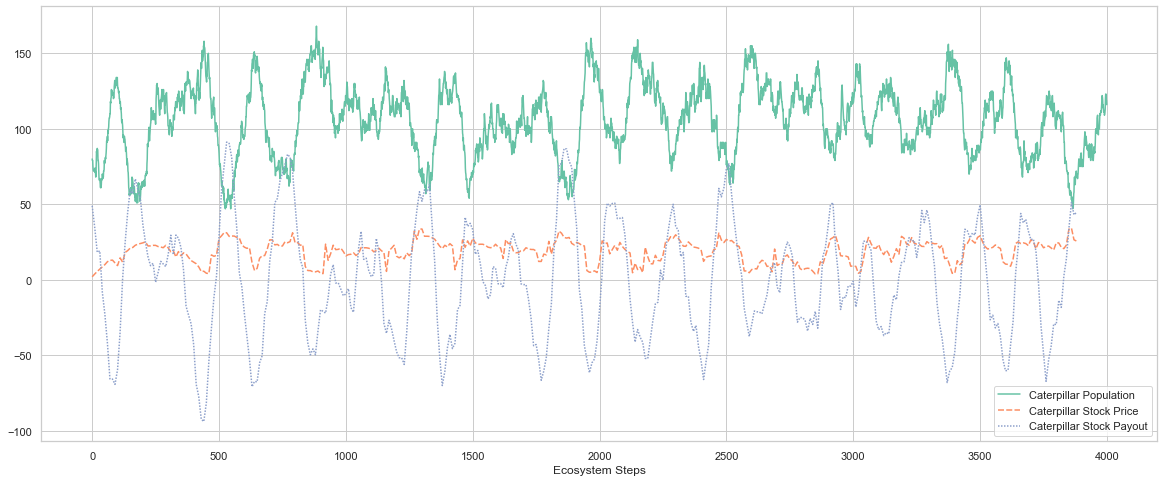

In [13]:
draw_stock_price_and_reward_graph('Caterpillar')

With caterpillar population swings being relatively easily predicted, and with payouts being regular, the price of caterpillar stock never spikes particularly high. The correlation is relatively strong, but more intense competition for less predictable stocks causes neurons that are good at valuation of caterpillars to be dropped in favour of more useful ones.

### Birds

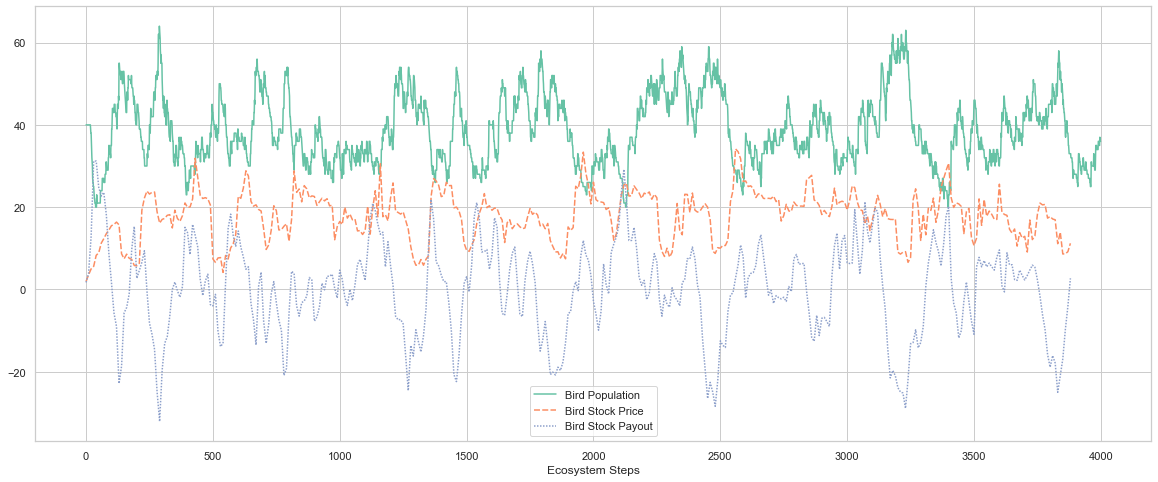

In [14]:
draw_stock_price_and_reward_graph('Bird')

Less predictable stocks cause larger price spikes as brokers compete for payouts wih higher certainty, and speculate more widely on uncertain payouts.

### Rabbits

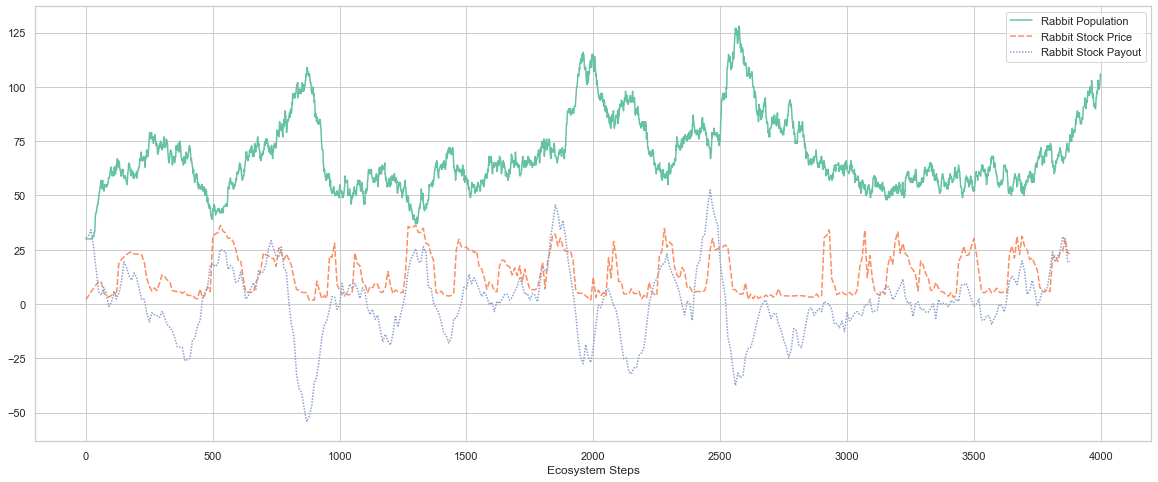

In [15]:
draw_stock_price_and_reward_graph('Rabbit')

The most predictable stock available, but with payouts distributed unevenly across just a few events cause the clearest correlation between the price and the returned value. There are a few odd moments, like at 3900 steps, where there is a high certainty of return from the spike in price, but the return barely breakes past zero. 

### Raptors

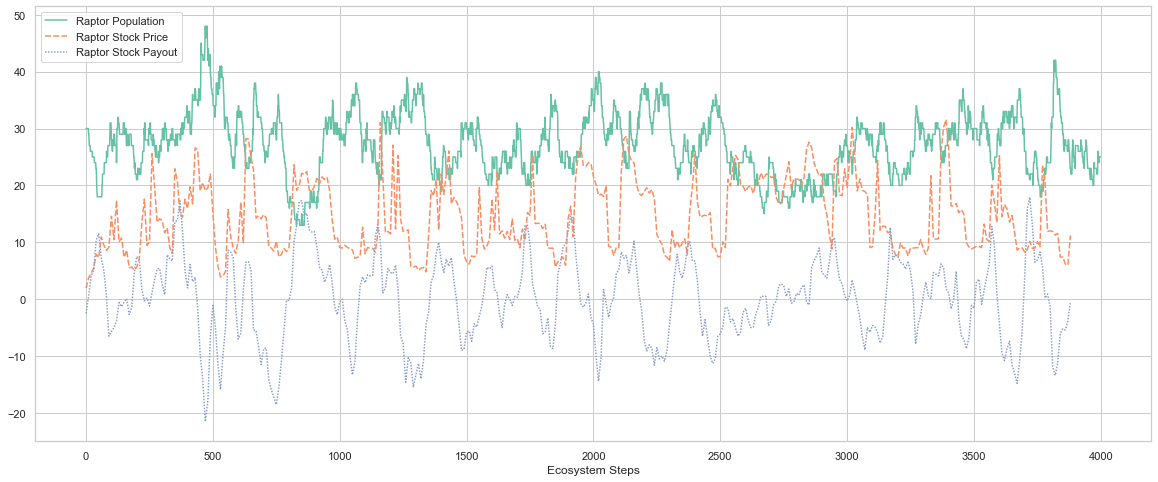

In [16]:
draw_stock_price_and_reward_graph('Raptor')

As the least predictable stock value, the relative return from investing in raptors has been amplified by the largest amount (see cell 8) in order to create the most significant and interesting speculation. Brokers waste larger amounts competing over raptor stock, as it is necessary to play the odds. 

### All Populations

Text(0.5, 0, 'Ecosystem Steps')

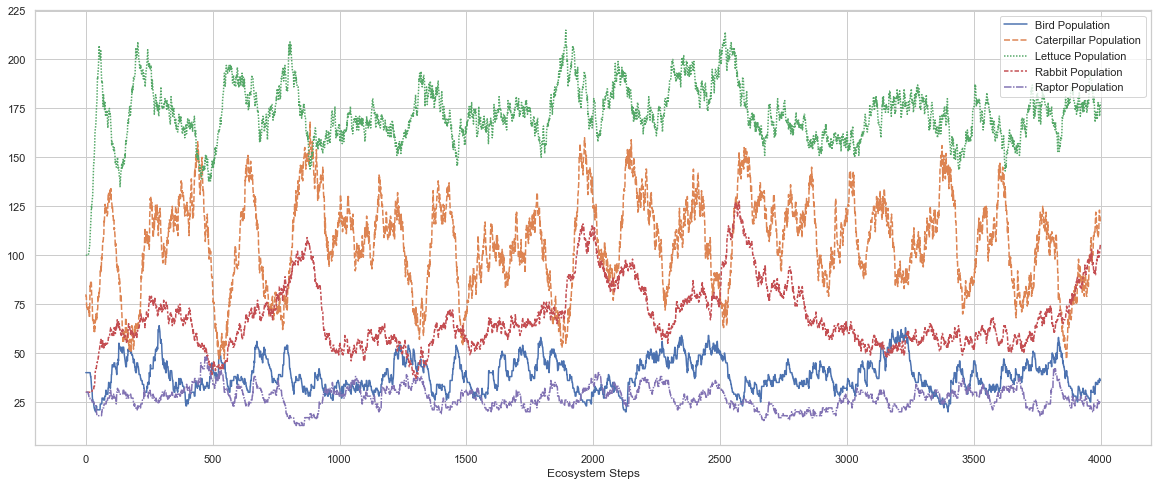

In [17]:
sns.set(rc={"figure.figsize":(20, 8)})
sns.set_style("whitegrid")
plot = sns.lineplot(data={
    'Bird Population': populations['Bird'], 
    'Caterpillar Population': populations['Caterpillar'], 
    'Lettuce Population': populations['Lettuce'], 
    'Rabbit Population': populations['Rabbit'],
    'Raptor Population': populations['Raptor'],
})
plot.set_xlabel("Ecosystem Steps")

### Further Notes

There are a few common behaviours in investment for all stocks:

- The minimum price is usually about five to eight, despite no payout from holding a stock when the population is about to decrease. This is due to the handful of randomly initialised brokers in each generation, which are happy to buy bad stocks at whatever they can afford. 

- There is no stock for which the reward and the price are perfectly correlated, and this is not entirely due to the inherent randomness of the ecosystem making prediction difficult. A lack or abundance of alternative opportunities often had a more significant impact.

- The 'saving up' functionality provided by an unused output was underutilised by brokers, implying that this functionality may be provided in a format which isn't suitable for consistent mutation towards its exploitation.

## Future Developments

Potential new features include, but are not limited to:

- Addition of a secondary model pretrained via backpropagation to act as rich inputs for the broker networks.
- Investigation of the weights of final models, as well as how weights change over successive generations in early training.
- Use of a significantly more complex ecosystem with a higher chance for an extinction.
- Investigation of the effects of greatly increasing broker complexity.
- Improving the trading such that brokers may exchange directly between one another via a matchup system.
- Move fitness and mutation down to the neuron level. Neurons cluster into many temporary brokers for competitive price discovery, and scores are instead aggregated over all brokers a neuron has belonged to.
- Adding monsters.

If you notice anything interesting while running this notebook or if you have any particularly entertaining ideas for further developments, please contact MGreenwood1994@gmail.com .